In [1]:
!pip install tensorflow 

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL



In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
import pathlib

In [7]:
dataset_path =  r"C:\Users\dhans\Downloads\Dhanshri_Fegade_TAS Intership\archive\tea sickness dataset"
dataset_dir = pathlib.Path(dataset_path)

In [10]:
class_names = ['white spot', 'Anthracnose', 'healthy', 'bird eye spot', 'brown blight', 'red leaf spot', 'gray light', 'algal leaf']
for x in os.walk(dataset_path):
    sub_dir = x[0]
    sub_dir_list = str(sub_dir).split('/')
    if len(sub_dir_list) > 4:
        x_class = (sub_dir_list[-1])
        class_names.append(x_class)

print(class_names)

['white spot', 'Anthracnose', 'healthy', 'bird eye spot', 'brown blight', 'red leaf spot', 'gray light', 'algal leaf']


In [11]:
for class_i in class_names:
    image_count = len(list(dataset_dir.glob(f'{class_i}/*.jpg')))
    print(f"Images in class {class_i}:",image_count)

Images in class white spot: 142
Images in class Anthracnose: 100
Images in class healthy: 74
Images in class bird eye spot: 100
Images in class brown blight: 113
Images in class red leaf spot: 143
Images in class gray light: 100
Images in class algal leaf: 113


In [12]:
train_batch = 128
val_batch = 128
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)
val_split = 0.2


In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                       validation_split=val_split,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=train_batch
                                                      )

Found 885 files belonging to 8 classes.
Using 708 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,                                                            
                                                     validation_split=val_split,                                                            
                                                     subset="validation",                                                     
                                                     seed=123,                                                     
                                                     image_size=(img_height, img_width),                                                     
                                                     batch_size=val_batch                                                           
                                                    )

Found 885 files belonging to 8 classes.
Using 177 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

num_classes=len(class_names)

['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


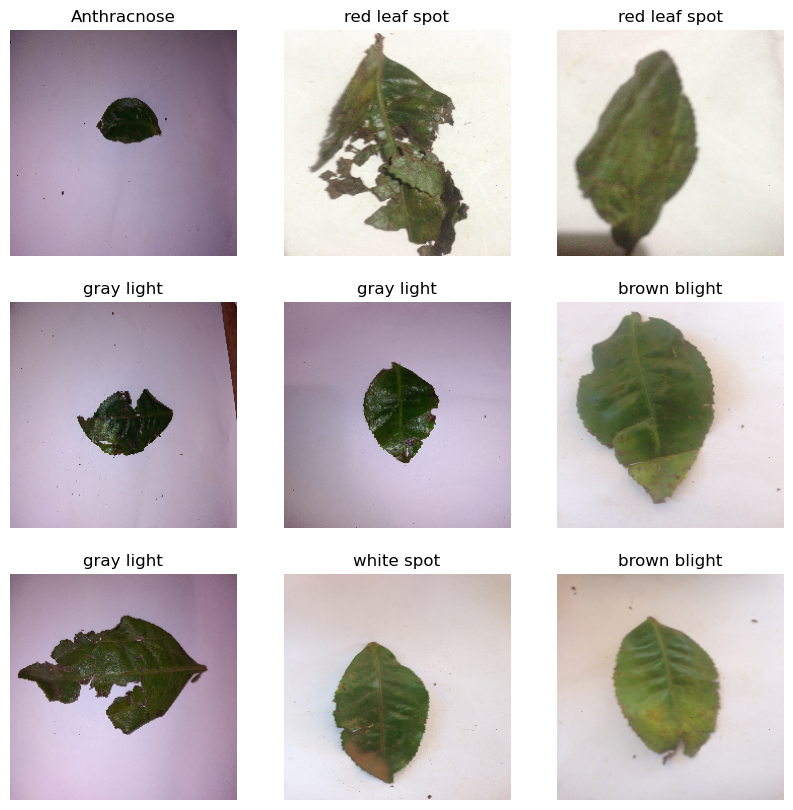

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [20]:

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(num_classes)
])

In [21]:
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 16)      2320      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 16)        0         
 g2D)                                                 

Predictions:
 [7 7 0 7 2 7 2 1 1 4 2 3 6 6 4 1 2 7 3 4 3 4 6 3 1 4 6 1 4 0 3 5 3 0 6 4 3
 6 4 4 7 6 6 4 0 2 6 3 1 3 6 2 3 4 4 7 6 1 5 0 6 4 2 4 1 6 4 6 7 5 3 7 3 2
 2 3 1 3 2 2 2 6 6 4 2 1 1 4 7 0 0 4 5 3 2 6 4 7 7 7 2 6 2 7 4 1 3 3 5 6 5
 5 7 6 1 3 2 3 7 0 3 4 7 4 4 7 3 4]
Labels:
 [3 7 2 7 0 7 2 1 1 4 0 7 7 6 0 1 2 3 3 4 3 0 6 3 7 4 1 1 0 4 7 5 3 0 6 4 3
 7 4 4 7 7 6 2 0 4 6 3 1 3 6 2 7 4 4 3 7 1 5 0 6 4 0 4 1 6 4 6 3 5 3 7 3 2
 2 7 1 3 2 0 4 6 6 0 0 1 1 4 7 0 0 4 5 3 2 6 4 7 7 3 2 6 0 7 4 1 3 3 5 6 5
 5 7 6 1 3 2 3 7 0 3 4 3 0 4 7 3 0]

              precision    recall  f1-score   support

           0       0.75      0.33      0.46        18
           1       0.92      0.92      0.92        13
           2       0.53      0.82      0.64        11
           3       0.81      0.74      0.77        23
           4       0.71      0.85      0.77        20
           5       1.00      1.00      1.00         7
           6       0.75      1.00      0.86        15
           7       0.

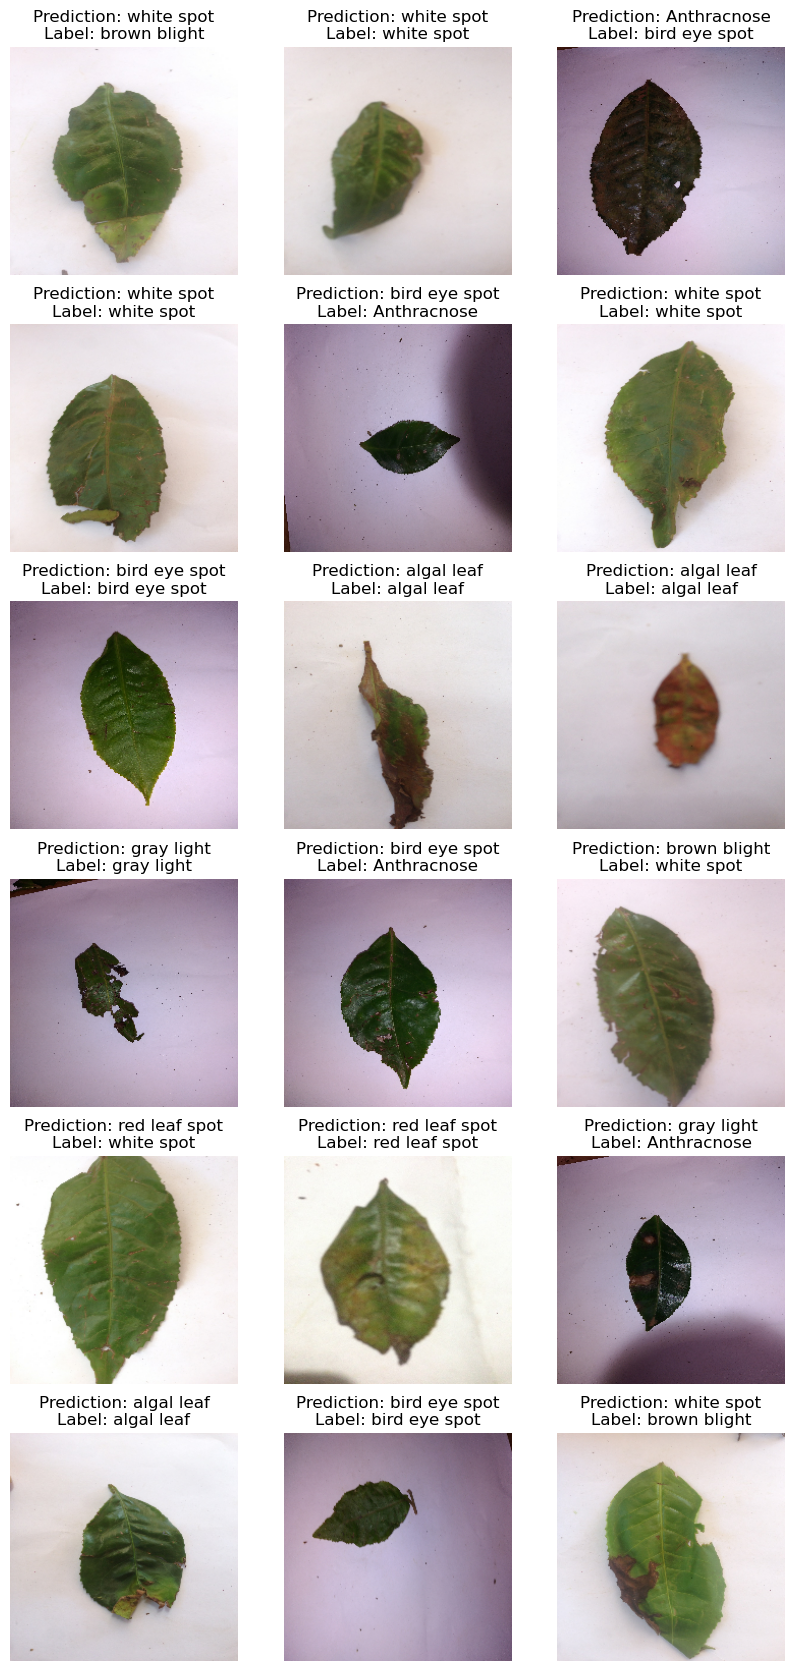

In [28]:
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")